<a href="https://colab.research.google.com/github/Jungkihong07/Deepwave/blob/main/cy_baseLine_code_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. 필요 라이브러러 임포트 및 다운로드

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [97]:
import os
import random
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt

# =========================
#  재현성 설정
# =========================
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

## 데이터 로딩 함수 정의

In [161]:
import os
import numpy as np
import tensorflow as tf

# 전역 하이퍼파라미터
SAMPLE_RATE       = 16000      # WAV 파일 샘플링 레이트
DESIRED_SECONDS   = 3          # 음성 길이를 3초로 고정
DESIRED_SAMPLES   = SAMPLE_RATE * DESIRED_SECONDS  # 48000 샘플

FRAME_LENGTH      = 512        # STFT 창 길이
FRAME_STEP        = 160        # STFT 홉 길이
FFT_LENGTH        = 512        # FFT 길이

NUM_MEL_BINS      = 40         # Mel 필터 개수
LOWER_EDGE_HERTZ  = 80.0       # Mel 필터 최소 주파수
UPPER_EDGE_HERTZ  = 7600.0     # Mel 필터 최대 주파수

NUM_MFCCS         = 20         # 추출할 MFCC 계수 개수


def load_mfcc_data_tf(audio_path, label_path, max_len=200):
    """
    audio_path: WAV 파일이 저장된 디렉터리
    label_path: 'filename label' 형식의 텍스트 파일 경로
    max_len: 프레임 수로 고정할 MFCC 길이 (부족 시 패딩, 넘치면 크롭)

    반환:
      X: (N, max_len, NUM_MFCCS) numpy array (float32)
      y: (N,) numpy array (int32), Real->0, Fake->1
    """
    filenames, labels = [], []
    with open(label_path, 'r') as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) < 2:
                continue
            filenames.append(parts[0])
            labels.append(0 if parts[1].lower() == 'real' else 1)

    X_list, y_list = [], []
    for fn, lbl in zip(filenames, labels):
        fp = os.path.join(audio_path, fn)
        if not tf.io.gfile.exists(fp):
            continue
        try:
            # 1) WAV 로드 및 mono 채널 확보
            audio_binary = tf.io.read_file(fp)
            audio, sr = tf.audio.decode_wav(audio_binary, desired_channels=1)
            audio = tf.squeeze(audio, axis=-1)

            # 2) 길이 고정 (패딩 또는 크롭)
            n_samples = tf.shape(audio)[0]
            audio_fixed = tf.cond(
                n_samples < DESIRED_SAMPLES,
                lambda: tf.pad(audio, [[0, DESIRED_SAMPLES - n_samples]], constant_values=0.0),
                lambda: audio[:DESIRED_SAMPLES]
            )

            # 3) STFT → Magnitude Spectrogram
            stfts = tf.signal.stft(
                audio_fixed,
                frame_length=FRAME_LENGTH,
                frame_step=FRAME_STEP,
                fft_length=FFT_LENGTH
            )
            spectrograms = tf.abs(stfts)

            # 4) Mel 필터뱅크 생성 및 Mel Spectrogram 계산
            num_spectrogram_bins = FFT_LENGTH // 2 + 1
            mel_weight_matrix = tf.signal.linear_to_mel_weight_matrix(
                NUM_MEL_BINS,
                num_spectrogram_bins,
                SAMPLE_RATE,
                LOWER_EDGE_HERTZ,
                UPPER_EDGE_HERTZ
            )
            mel_spectrograms = tf.matmul(tf.square(spectrograms), mel_weight_matrix)

            # 5) 로그 변환 → MFCC 계산
            log_mel = tf.math.log(mel_spectrograms + 1e-6)
            mfccs_full = tf.signal.mfccs_from_log_mel_spectrograms(log_mel)
            mfccs = mfccs_full[:, :NUM_MFCCS]

            # 6) 프레임 수 맞추기 (패딩 또는 크롭)
            n_frames = tf.shape(mfccs)[0]
            mfccs_fixed = tf.cond(
                n_frames < max_len,
                lambda: tf.pad(mfccs, [[0, max_len - n_frames], [0, 0]], constant_values=0.0),
                lambda: mfccs[:max_len, :]
            )

            X_list.append(mfccs_fixed.numpy().astype('float32'))
            y_list.append(lbl)
        except Exception:
            continue

    if not X_list:
        return np.empty((0, max_len, NUM_MFCCS), dtype='float32'), np.empty((0,), dtype='int32')

    X_arr = np.stack(X_list, axis=0)
    y_arr = np.array(y_list, dtype='int32')
    return X_arr, y_arr


### 데이터 셋 캐시 저장
- 사용 예시
save_mfcc_cache(X, y, scaler, cache_prefix="train")
- 사용 조건
  - 목차의 "캐시가 없을 때"를 실행하고 난 후 실행하셔야 합니다.

#### Train set 캐시 저장 함수
- test set을 위한 코드가 아닙니다. train set에만 사용하시기 바랍니다.

In [99]:
def save_mfcc_cache(X, y, scaler, cache_prefix="train"):
    X_cache = f"{cache_prefix}_X.npy"
    y_cache = f"{cache_prefix}_y.npy"
    scaler_cache = f"{cache_prefix}_scaler.npy"

    np.save(X_cache, X)
    np.save(y_cache, y)
    np.save(scaler_cache, {'mean': scaler.mean_, 'scale': scaler.scale_})
    print(f"✅ 캐시 저장 완료: {X_cache}, {y_cache}, {scaler_cache}")
# Train set = > X: 전처리된 입력 특성, y : 정답 레이블, scaler : 표준화 정보
save_mfcc_cache(X, y, scaler, cache_prefix="train")

✅ 캐시 저장 완료: train_X.npy, train_y.npy, train_scaler.npy


#### Test set 캐시 저장
-  test set을 위한 코드입니다.

In [112]:

# Test set => X_test : 입력 특성, y_test : 정답 레이블, 표준화 정보는 필요없음. scalar를 사용해야 함.
np.save("test_X.npy", X_test)
np.save("test_y.npy", y_test)
print("✅ 테스트셋 캐시 저장 완료")


✅ 테스트셋 캐시 저장 완료


### 캐시로부터 MFCC 데이터 로드 함수
- 사용 예시
X, y, scaler = load_mfcc_cache(cache_prefix="train")
- 사용 조건
  - 이후 캐시를 저장하고 난 후는 계속해서 MFCC 데이터 로드 함수를 활용해 이후, 로드할 필요 없이 사용하시면 됩니다.

#### Train set 캐시 로드 함수

In [101]:
def load_mfcc_cache(cache_prefix="train"):
    X_cache = f"{cache_prefix}_X.npy"
    y_cache = f"{cache_prefix}_y.npy"
    scaler_cache = f"{cache_prefix}_scaler.npy"

    if not (os.path.exists(X_cache) and os.path.exists(y_cache) and os.path.exists(scaler_cache)):
        raise FileNotFoundError(f"❌ 캐시 파일이 존재하지 않습니다: prefix={cache_prefix}")

    print(f"📂 캐시 불러오는 중: {X_cache}, {y_cache}")
    X = np.load(X_cache)
    y = np.load(y_cache)
    scaler_params = np.load(scaler_cache, allow_pickle=True).item()

    scaler = StandardScaler()
    scaler.mean_ = scaler_params['mean']
    scaler.scale_ = scaler_params['scale']

    return X, y, scaler
# Train set
X, y, scaler = load_mfcc_cache(cache_prefix="train")

📂 캐시 불러오는 중: train_X.npy, train_y.npy


#### test set 캐시 로드

In [113]:
# Test set
X_test = np.load("test_X.npy")
y_test = np.load("test_y.npy")
print("✅ 테스트셋 캐시 불러오기 완료")

✅ 테스트셋 캐시 불러오기 완료


## DNN 모델 정의

모델 설명:

입력으로 MFCC 스펙트로그램(max_len×NUM_MFCCS) 사용함.

Flatten으로 시계열 정보 1D 벡터로 펼침.

Dense(512) 통과 후 BatchNormalization → ReLU 적용 → Dropout(0.3) 적용함.

이어서 Dense(256) → BatchNormalization → ReLU → Dropout(0.3) 순으로 처리함.

다시 Dense(128) → BatchNormalization → ReLU → Dropout(0.3) 순으로 처리함.

마지막에 Dense(1, activation='sigmoid')로 Real/Fake 확률 출력함.

컴파일 시 Adam(learning_rate=1e-3) 옵티마이저, binary_crossentropy 손실 사용함.

학습 중 accuracy 지표 기록함.




Input shape: (max_len, NUM_MFCCS)
Flatten: 시계열 MFCC 정보를 1D 벡터로 펼침

DNN 구조:
Dense(512) + BatchNormalization + ReLU + Dropout(0.3)

Dense(256) + BatchNormalization + ReLU + Dropout(0.3)

Dense(128) + BatchNormalization + ReLU + Dropout(0.3)

Dense(1, activation='sigmoid') → Real/Fake 확률 출력

In [164]:
from tensorflow.keras import layers, models
import tensorflow as tf

def build_dnn_model(input_shape):
    """
    input_shape: (max_len, NUM_MFCCS), 예: (200, 20)
    이진 분류를 위한 DNN 모델 (Dense 계층만 사용)
    """
    model = models.Sequential([
        # 입력: MFCC 스펙트로그램 (max_len × NUM_MFCCS)
        layers.Input(shape=input_shape, name="input_mfcc"),

        # Flatten 후 첫 번째 Dense 블록
        layers.Flatten(name="flatten"),
        layers.Dense(512, activation=None, name="dense1"),
        layers.BatchNormalization(name="bn1"),
        layers.Activation('relu', name="act1"),
        layers.Dropout(0.3, name="drop1"),

        # 두 번째 Dense 블록
        layers.Dense(256, activation=None, name="dense2"),
        layers.BatchNormalization(name="bn2"),
        layers.Activation('relu', name="act2"),
        layers.Dropout(0.3, name="drop2"),

        # 세 번째 Dense 블록
        layers.Dense(128, activation=None, name="dense3"),
        layers.BatchNormalization(name="bn3"),
        layers.Activation('relu', name="act3"),
        layers.Dropout(0.3, name="drop3"),

        # 출력: 이진 분류 (sigmoid)
        layers.Dense(1, activation='sigmoid', name="output")
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model


## 학습용 데이터 로딩

In [9]:
train_audio_path = '/content/drive/MyDrive/2501ml_data/train'
train_label_path = '/content/drive/MyDrive/2501ml_data/label/train_label.txt'
max_len = 200

### 캐시가 없을 때
- 캐시가 있다면 목차의 "캐시로부터 MFCC 데이터 로드 함수"를 실행하고 난후 다음 단계로 넘어가주시기 바랍니다.

In [10]:
X, y = load_mfcc_data(train_audio_path, train_label_path, max_len)
X, scaler = standardize(X)

Loading MFCC: 100%|██████████| 4000/4000 [19:35<00:00,  3.40it/s]


# 모델 학습

Model: "sequential_24"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 2600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense1 (Dense)                  │ (None, 512)            │     1,331,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn1 (BatchNormalization)        │ (None, 512)            │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ act1 (Activation)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop1 (Dropout)                 │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense2 (Dense)                  │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn2 (BatchNormalization)        │ (None, 256)            │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ act2 (Activation)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop2 (Dropout)                 │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense3 (Dense)                  │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn3 (BatchNormalization)        │ (None, 128)            │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ act3 (Activation)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop3 (Dropout)                 │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,499,649 (5.72 MB)

 Trainable params: 1,497,857 (5.71 MB)

 Non-trainable params: 1,792 (7.00 KB)

Epoch 1/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.8798 - loss: 0.2851 - val_accuracy: 0.9625 - val_loss: 0.1438 - learning_rate: 0.0010
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9957 - loss: 0.0277 - val_accuracy: 0.9875 - val_loss: 0.0542 - learning_rate: 0.0010
Epoch 3/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9996 - loss: 0.0094 - val_accuracy: 0.9925 - val_loss: 0.0411 - learning_rate: 0.0010
Epoch 4/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0053 - val_accuracy: 0.9925 - val_loss: 0.0425 - learning_rate: 0.0010
Epoch 5/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 0.0027 - val_accuracy: 0.9925 - val_loss: 0.0395 - learning_rate: 0.0010
Epoch 6/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 1.0000 - loss: 0.0015 - val_accuracy: 0.9925 - val_loss: 0.0384 - learning_rate: 0.0010
Epoch 7/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0013 - 

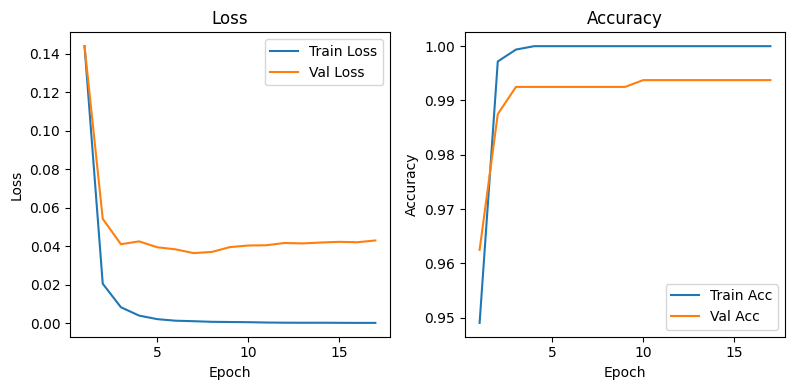

In [185]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# ----------------------------------------------------
# 가정: X, y는 이미 load_mfcc_data_tf() 등을 통해 준비된 상태
# X.shape == (N, max_len, n_mfcc),  y.shape == (N,)
# ----------------------------------------------------
max_len = X.shape[1]      # 예: 200
n_mfcc  = X.shape[2]      # 예: 13

# ----------------------------------------------------
# 1) Train/Validation 분할 (클래스 비율 유지)
# ----------------------------------------------------
X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.2,       # 검증 비율 20%
    stratify=y,          # 클래스 비율 유지
    random_state=41      # 재현성 고정
)

# ----------------------------------------------------
# 2) DNN 모델 생성 (입력 형태: (max_len, n_mfcc))
# ----------------------------------------------------
def build_dnn_model(input_shape):
    """
    input_shape: (max_len, n_mfcc) 형태, 예: (200, 13)
    이진 분류를 위한 DNN 모델 (Dense 계층만 사용)
    """
    model = tf.keras.Sequential([
        # 1) 입력 레이어: MFCC 스펙트로그램
        tf.keras.layers.Input(shape=input_shape, name="input_mfcc"),

        # 2) Flatten → Dense Block #1
        tf.keras.layers.Flatten(name="flatten"),
        tf.keras.layers.Dense(512, activation=None, name="dense1"),
        tf.keras.layers.BatchNormalization(name="bn1"),
        tf.keras.layers.Activation('relu', name="act1"),
        tf.keras.layers.Dropout(0.3, name="drop1"),

        # 3) Dense Block #2
        tf.keras.layers.Dense(256, activation=None, name="dense2"),
        tf.keras.layers.BatchNormalization(name="bn2"),
        tf.keras.layers.Activation('relu', name="act2"),
        tf.keras.layers.Dropout(0.3, name="drop2"),

        # 4) Dense Block #3
        tf.keras.layers.Dense(128, activation=None, name="dense3"),
        tf.keras.layers.BatchNormalization(name="bn3"),
        tf.keras.layers.Activation('relu', name="act3"),
        tf.keras.layers.Dropout(0.3, name="drop3"),

        # 5) 출력 레이어: sigmoid 활성화로 이진 분류
        tf.keras.layers.Dense(1, activation='sigmoid', name="output")
    ])

    # 컴파일: Adam 옵티마이저 + binary_crossentropy + accuracy 지표
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

# 모델 생성 및 요약 출력
model = build_dnn_model(input_shape=(max_len, n_mfcc))
model.summary()

# ----------------------------------------------------
# 3) 콜백 설정
# ----------------------------------------------------
callbacks = [
    # val_loss 개선 없으면 조기 종료 (최대 10 에포크 대기)
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    # val_loss 개선 없으면 학습률 절반으로 감소 (최대 5 에포크 대기)
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)
]

# ----------------------------------------------------
# 4) 모델 학습
# ----------------------------------------------------
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,          # 최대 50 에포크
    batch_size=32,      # 배치 크기 32
    callbacks=callbacks,
    verbose=1           # 프로그레스 바 출력
)

# ----------------------------------------------------
# 5) 학습 이력 시각화 함수
# ----------------------------------------------------
def plot_history_with_auc(history):
    hist = history.history
    epochs = range(1, len(hist['loss']) + 1)

    plt.figure(figsize=(12, 4))

    # 1) Loss 곡선
    plt.subplot(1, 3, 1)
    plt.plot(epochs, hist['loss'],     label='Train Loss', color='tab:blue')
    plt.plot(epochs, hist['val_loss'], label='Val Loss',   color='tab:orange')
    plt.title("Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    # 2) Accuracy 곡선
    plt.subplot(1, 3, 2)
    plt.plot(epochs, hist['accuracy'],     label='Train Acc',  color='tab:blue')
    plt.plot(epochs, hist['val_accuracy'], label='Val Acc',    color='tab:orange')
    plt.title("Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.tight_layout()
    plt.show()

# ----------------------------------------------------
# 6) 학습 과정 시각화 호출
# ----------------------------------------------------
plot_history_with_auc(history)


## 모델 학습 과정 시각화

# 테스트 데이터 로딩 및 평가

In [88]:
test_audio_path = '/content/drive/MyDrive/2501ml_data/test'
test_label_path = '/content/drive/MyDrive/2501ml_data/label/test_label.txt'

### 캐시가 없을 때
- 캐시가 있다면 목차의 "캐시로부터 MFCC 데이터 로드 함수"를 실행하고 난후 다음 단계로 넘어가주시기 바랍니다.
- 캐시를 생성하고 싶다면 목차의 "데이터 셋 캐시 저장"을 실행하시기 바립니다.

In [110]:
X_test, y_test = load_mfcc_data(test_audio_path, test_label_path, max_len)
ns_test = X_test.shape[0]
X_test, _ = standardize(X_test)

Loading MFCC: 100%|██████████| 2000/2000 [00:29<00:00, 68.96it/s]


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step

✅ Classification Report - TEST DATA
              precision    recall  f1-score   support

        Real       0.87      1.00      0.93       999
        Fake       1.00      0.84      0.91      1000

    accuracy                           0.92      1999
   macro avg       0.93      0.92      0.92      1999
weighted avg       0.93      0.92      0.92      1999

ROC AUC: 0.917


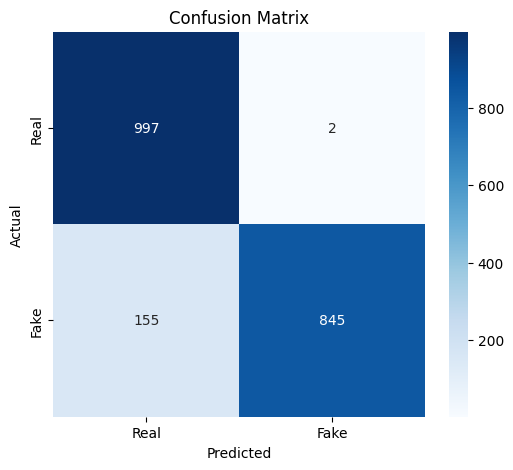

In [186]:
# -------------------------------------------
# 6. 테스트 데이터 평가
# -------------------------------------------

y_prob = model.predict(X_test)
y_pred = (y_prob > 0.5).astype(int)

print("\n✅ Classification Report - TEST DATA")
print(classification_report(y_test, y_pred, target_names=['Real','Fake']))
print(f"ROC AUC: {roc_auc_score(y_test, y_prob):.3f}")

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Real','Fake'], yticklabels=['Real','Fake'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


이거 드라이브에 2000개 있고 캐시로 업로드된 데이터 2000개인데 왜 1999개인지는 아직 파악을 못했습니다..

# 예측 결과 파일 작성

In [187]:
from sklearn.preprocessing import LabelEncoder

# 1. test 파일명 리스트 로딩
def get_test_filenames(label_path):
    filenames = []
    with open(label_path, 'r') as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) >= 5:
                filenames.append(parts[1])
    return filenames

# 2. LabelEncoder: Fake → 0, Real → 1
le = LabelEncoder()
le.fit(['Fake', 'Real']) # 반드시 이 순서로 지정해야 0=Fake, 1=Real

# 3. 파일 이름 로드
test_file_names = get_test_filenames(test_label_path)

# 4. 예측 확률 → 클래스 (0 또는 1) => 정규화 방식에 따라 정확도가 차이가 남.
y_pred_prob = model.predict(X_test)
# y_pred_classes = np.argmax(y_pred_prob, axis=1)
y_pred_classes = (y_pred_prob < 0.5).astype(int).flatten()  # 확률 → 0 or 1


# 5. 예측 결과 파일 작성
with open('./team_test_result.txt', 'w') as f:
    for i in range(len(y_pred_classes)):
        label_str = le.inverse_transform([y_pred_classes[i]])[0]  # 0 → Fake, 1 → Real
        f.write(f"{test_file_names[i]} {label_str}\n")

print("✅ team_test_result.txt 저장 완료 (Perl 평가용)")

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
✅ team_test_result.txt 저장 완료 (Perl 평가용)


In [188]:
!perl /content/drive/MyDrive/2501ml_data/eval.pl ./team_test_result.txt /content/drive/MyDrive/2501ml_data/label/test_label.txt

============ Results Analysis ===========
Test: ./team_test_result.txt
True: /content/drive/MyDrive/2501ml_data/label/test_label.txt
Accuracy: 92.10%
Hit: 1841, Total: 1999
